<a href="https://colab.research.google.com/github/beedrumms/Exploring-Public-Responses-to-Government-COVID-19-Policies/blob/main/2)_A)_ON_Tweet_EDA_Before_Preprocessing_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import essential packages for preprocessing steps
import re 
import string
import pandas as pd
import numpy as np
from google.colab import drive, files
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime
# Mounting google colab on drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import essential packages and download my dataset from my drive 
data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ONTARIOS_COVID19_TWEETS.csv')
# Filtering columns to just the date, tweet id, and the actual tweet 
filtered_data1 = data1[['Datetime', 'Text']]
filtered_data1.drop_duplicates(subset=['Text'], inplace=True)
filtered_data1.shape # ensuring everthing read in properly

(421109, 2)

In [ ]:
# Creating a text cleaning function with regex
# the function will make everything lowercase, remove @usernames, punctuation, save the propnoun fordnation, remove digits, and remove links 
def tweets_first_clean(tweets):
    tweets = tweets.lower()
    tweets = re.sub('[.?-_;:&*\]]', '',  tweets) 
    tweets = re.sub('@fordnation', 'fordnation', tweets)
    tweets = re.sub('@\w{0,18}[a-zA-Z0-9_]','', tweets) 
    tweets = re.sub('[0-9]', '', tweets)
    tweets = re.sub('https?://[A-Za-z0-9./]+','',tweets)
    tweets = re.sub(r'w{3}.\w+.\w+','',tweets)
    return tweets

basic_preprocessing = lambda x: tweets_first_clean(x)

In [ ]:
# Creating a emoji removing function 
def removing_emojis(text):
  regrex_pattern = re.compile(pattern = "["
  u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags = re.UNICODE)
  return regrex_pattern.sub(r'',text)

emoji_removal = lambda x: removing_emojis(x)

In [ ]:
# copying my not clean dataset so if I make a mistake I can return to this copy without rerunning all of the above code 
tweet_data = filtered_data1.copy()

# Re copying my dataset again so if I have a clean and not clean copy
clean_tweet_data = tweet_data.copy()

In [ ]:
# Cleaning my text data
clean_tweet_data.Text = pd.DataFrame(clean_tweet_data.Text.apply(emoji_removal))
clean_tweet_data.Text = pd.DataFrame(clean_tweet_data.Text.apply(basic_preprocessing))

In [ ]:
# making a word cloud for my unclean tweet data 
unclean_str = []
for t in tweet_data.Text:
  unclean_str.append(t)
unclean_str = pd.Series(unclean_str).str.cat(sep=' ')

# making a word cloud for my clean tweet data
clean_str = []
for t in clean_tweet_data.Text:
  clean_str.append(t)
clean_str = pd.Series(clean_str).str.cat(sep=' ')

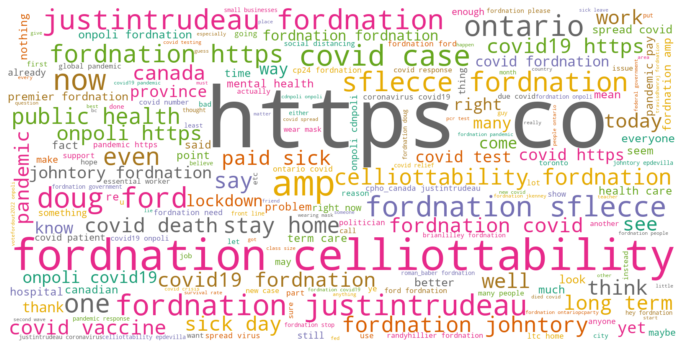

In [ ]:
# unclean word cloud
unclean_wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color="white", colormap="Dark2").generate(unclean_str)
plt.figure(figsize=(12,10))
plt.imshow(unclean_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

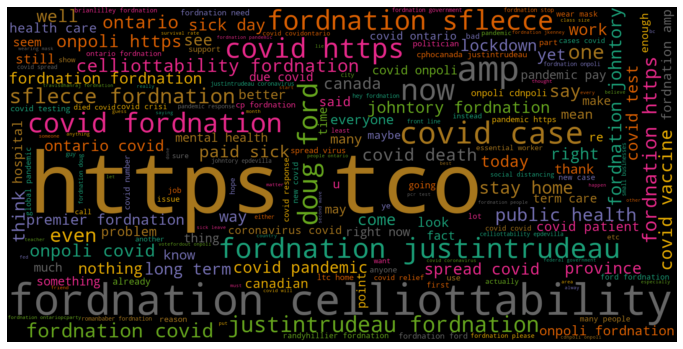

In [ ]:
# clean word cloud
clean_wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color="black", colormap="Dark2").generate(clean_str)
plt.figure(figsize=(12,10))
plt.imshow(clean_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Some popular things we can observe after the first cleaning are Doug Ford's twitter handle, Christine Elliot's twitter handle, Justin Trudeau's handle, Minister of Eduction (Ontario)'s handle, and John Tory's twitter handle. Keywords look like pandemix, covid case, one, and then these three big words that don't make sense - https, tco, and amp. I'm going to have to clean more to remove these words and parse others correctly. 

In [ ]:
# Its clear that my regex for removing https is not working and there is this werid word 'tco' that I do not recognize
  # going to check these two things out using a for loop
for t in clean_tweet_data.Text[:200]:
  if 'https' or 'tco' in t: 
    print(t)
# looking we can see that https and tco are part of the same broken link that is being missed because the http link does not have a colon

In [ ]:
# going to check this other outstanding 'amp' 
for t in tweet_data.Text[:200]:
  if ' amp ' in t: 
    print(t)
# it looks like ' amp ' may be a conversion error from ampersand (&) 

In [ ]:
# Given how popular pronouns are in the word cloud and how I used Ontario Government ministry handles / politicians to approximate location
# and given how often https pops up without a :, I will expand my regex function to: 
  # replace politician names with their handle
  # replace ministry titles with their official accroynm 
  # get rid of https

def tweets_second_clean(tweets):
    tweets = tweets.lower()
    tweets = re.sub('https?://[A-Za-z0-9./]+','',tweets) #remove links 
    tweets = re.sub('https?//[A-Za-z0-9./]+','',tweets) #remove broken links that do not have a colon
    tweets = re.sub(r'w{3}.\w+.\w+','',tweets) # remove other links with www
    tweets = re.sub('[\\r\\n?|\\n]','',tweets) # remove carrige returns and new lines
    tweets = re.sub('#[a-zA-Z0-9-_]+', '', tweets) # remove all hashtags
    tweets = re.sub('\s[&]amp[;]\s',' and ',tweets)
    tweets = re.sub('@\w{0,18}[a-zA-Z0-9_]','', tweets) # remove all usernames
    tweets = re.sub('[#\'".%\?\,-_;:\\&*\]]', '',  tweets) # remove all punctuation
    tweets = re.sub('[’“”]', '', tweets) # removing this weird apostrophe that a regular apostrophe wont get rid of  
    tweets = re.sub('[0-9’]', '', tweets) # remove digits 
    return tweets

preprocessing = lambda x: tweets_second_clean(x)

In [ ]:
# rewriting unclean dataset again to keep everything separate 
clean_tweet_data2 = data1.copy() 
# Cleaning my text data again from the unclean set by reapplying my revised cleaning function
clean_tweet_data2.Text = pd.DataFrame(clean_tweet_data2.Text.apply(emoji_removal))
clean_tweet_data2.Text = pd.DataFrame(clean_tweet_data2.Text.apply(preprocessing))

In [ ]:
# making a word cloud for my second round of preprocessing tweet data
clean_str2 = []
for t in clean_tweet_data2.Text:
  clean_str2.append(t)
clean_str2 = pd.Series(clean_str2).str.cat(sep=' ')

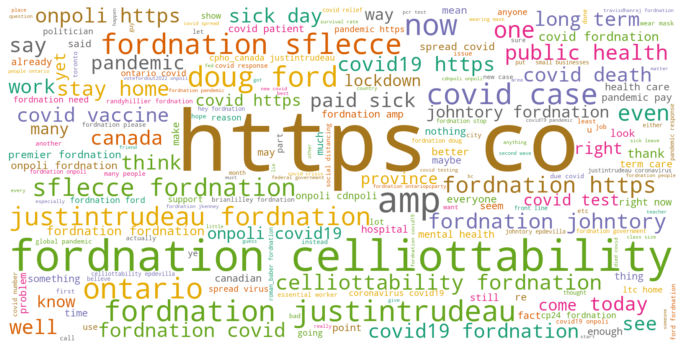

In [ ]:
# unclean word cloud comparing with newly clean cloud
unclean_wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color="white", colormap="Dark2").generate(unclean_str)
plt.figure(figsize=(12,10))
plt.imshow(unclean_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

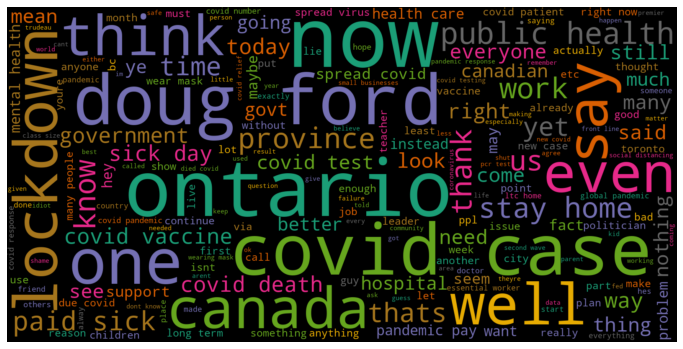

In [ ]:
# second round of clean data - clean2 word cloud
clean_wordcloud2 = WordCloud(width=1600, height=800, max_font_size=200, background_color="black", colormap="Dark2").generate(clean_str2)
plt.figure(figsize=(12,10))
plt.imshow(clean_wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()
# below looks a lot better

### The above looks a lot cleaner and we can see some clear key terms related to covid policy